In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'])

In [3]:
sales_j= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_j.shape

(60, 2)

In [5]:
sales_j.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_j['Sales'].sum()

4532957

In [7]:
sales_j = sales_j.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_j.head()

ds      y
0 2019-01-01  63722
1 2019-02-01  76987
2 2019-03-01  99645
3 2019-04-01  68529
4 2019-05-01  45119

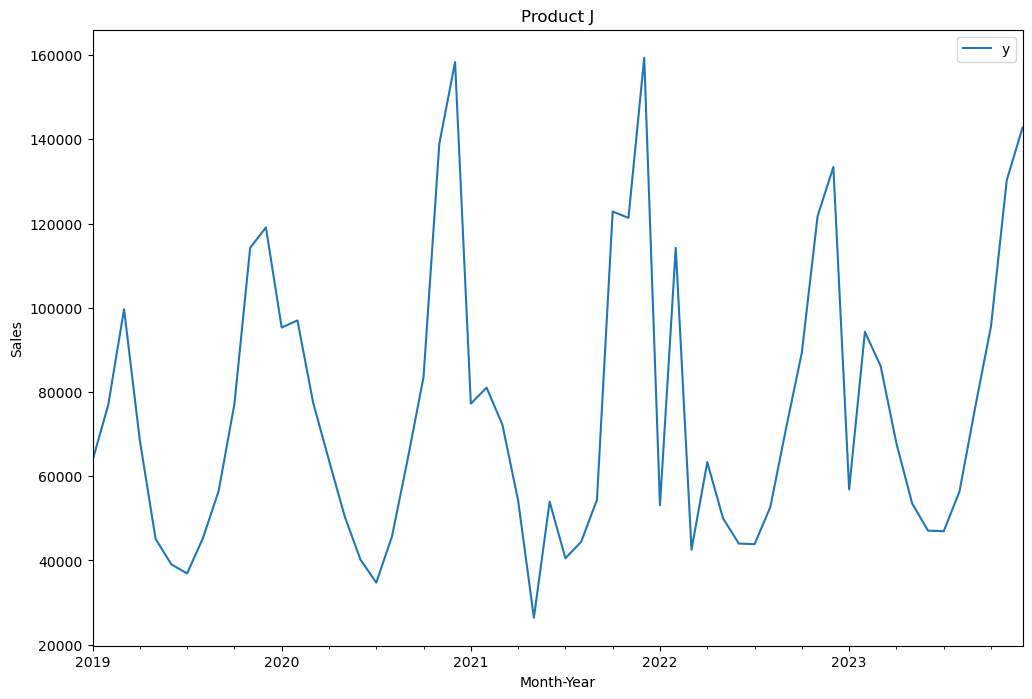

In [8]:
ax = sales_j.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product J')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_j['y'])

ADF Statistics: -2.3759301997991913
p- value: 0.14864548261740318
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
train= sales_j[:48]
test=sales_j[48:]

# Hyperparameter Tuning

In [13]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

13:13:14 - cmdstanpy - INFO - Chain [1] start processing
13:13:14 - cmdstanpy - INFO - Chain [1] done processing
13:13:17 - cmdstanpy - INFO - Chain [1] start processing
13:13:17 - cmdstanpy - INFO - Chain [1] done processing
13:13:20 - cmdstanpy - INFO - Chain [1] start processing
13:13:20 - cmdstanpy - INFO - Chain [1] done processing
13:13:23 - cmdstanpy - INFO - Chain [1] start processing
13:13:26 - cmdstanpy - INFO - Chain [1] done processing
13:13:31 - cmdstanpy - INFO - Chain [1] start processing
13:13:32 - cmdstanpy - INFO - Chain [1] done processing
13:13:36 - cmdstanpy - INFO - Chain [1] start processing
13:13:37 - cmdstanpy - INFO - Chain [1] done processing
13:13:40 - cmdstanpy - INFO - Chain [1] start processing
13:13:40 - cmdstanpy - INFO - Chain [1] done processing
13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing
13:13:47 - cmdstanpy - INFO - Chain [1] start processing
13:13:49 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   34275.284853  
1   36663.791613  
2   20014.831142  
3   22661.536854  
4   18817.293530  
..       

In [14]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
10                    0.001                    10.00         additive   
22                    0.010                    10.00         additive   
18                    0.010                     3.00         additive   
20                    0.010                     5.00         additive   
32                    0.100                     5.00         additive   
..                      ...                      ...              ...   
25                    0.100                     0.01   multiplicative   
61                    0.500                     0.01   multiplicative   
64                    0.500                     1.00         additive   
1                     0.001                     0.01   multiplicative   
63                    0.500                     0.10   multiplicative   

            rmse  
10  18562.488078  
22  18597.682973  
18  18608.296054  
20  18614.611194  
32  18616.086684  
..           ...  
25  34910.794333  
61  34955.516331  
64  35022.186128  
1   36663.791613  
63  38034.570567  

[72 rows x 4 columns]

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


In [16]:
# Create a Prophet model
model = Prophet( changepoint_prior_scale= 0.001,seasonality_prior_scale=10.0, seasonality_mode = 'additive',
                interval_width=0.95)

In [17]:
model.fit(train)

13:17:54 - cmdstanpy - INFO - Chain [1] start processing
13:17:55 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [19]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [20]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [21]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
48 2023-01-01   79300.864451   57722.607679  101972.023021
49 2023-02-01   95347.127062   75893.498900  116816.554491
50 2023-03-01   77320.735604   55841.119596   99677.458707
51 2023-04-01   63147.298311   40151.302846   84410.205433
52 2023-05-01   41274.511670   20562.448236   61747.593497
53 2023-06-01   41211.123224   20405.467991   62542.451928
54 2023-07-01   42717.175570   21168.040406   63448.087250
55 2023-08-01   53542.331294   32752.082720   73609.858973
56 2023-09-01   69224.883073   47415.519297   91258.272268
57 2023-10-01   94991.904804   71861.147560  116894.802390
58 2023-11-01  122728.235740   99606.301066  143944.838927
59 2023-12-01  128393.456210  106419.547587  151358.314682

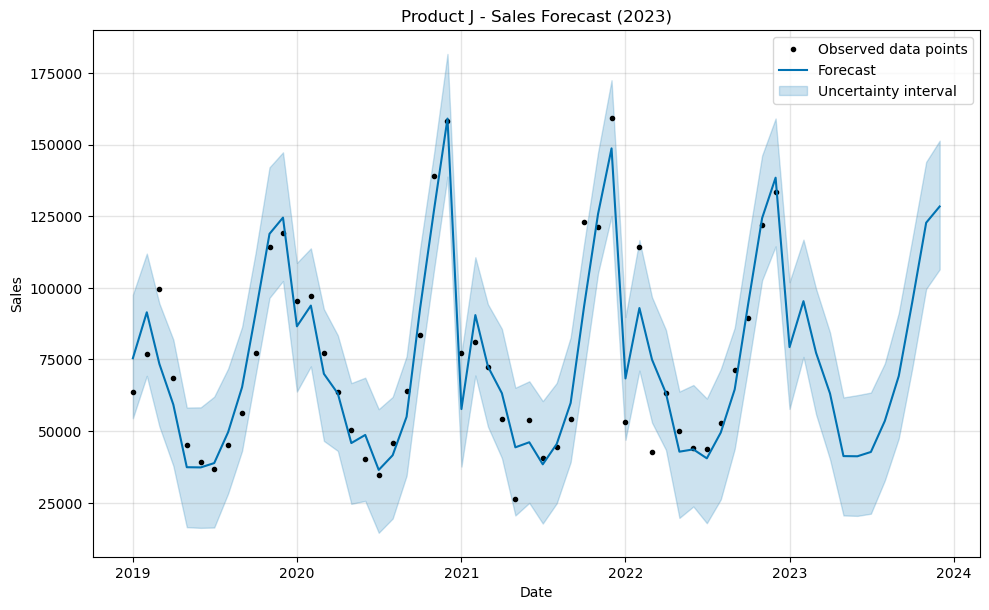

In [22]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product J - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

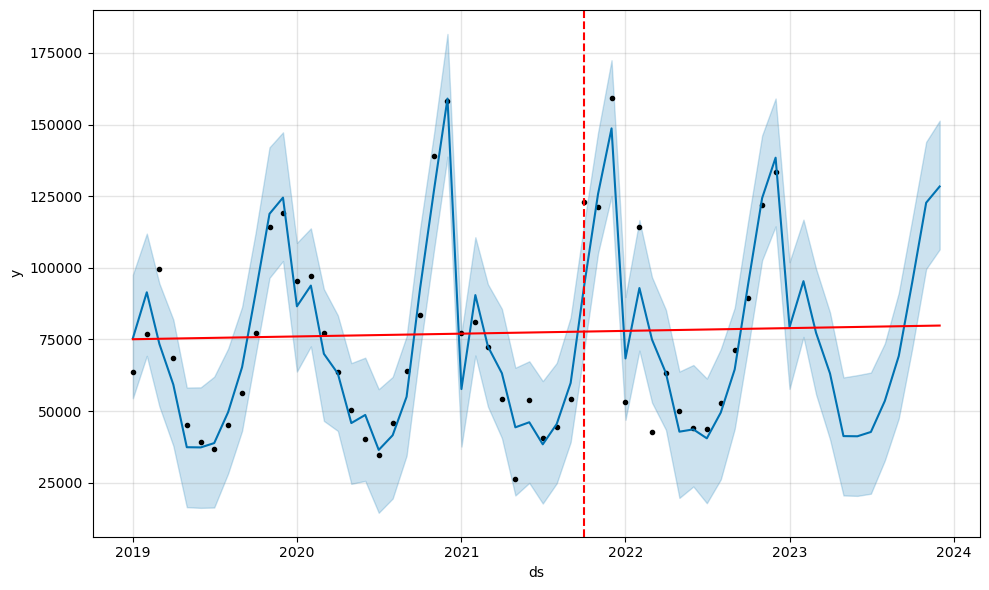

In [23]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

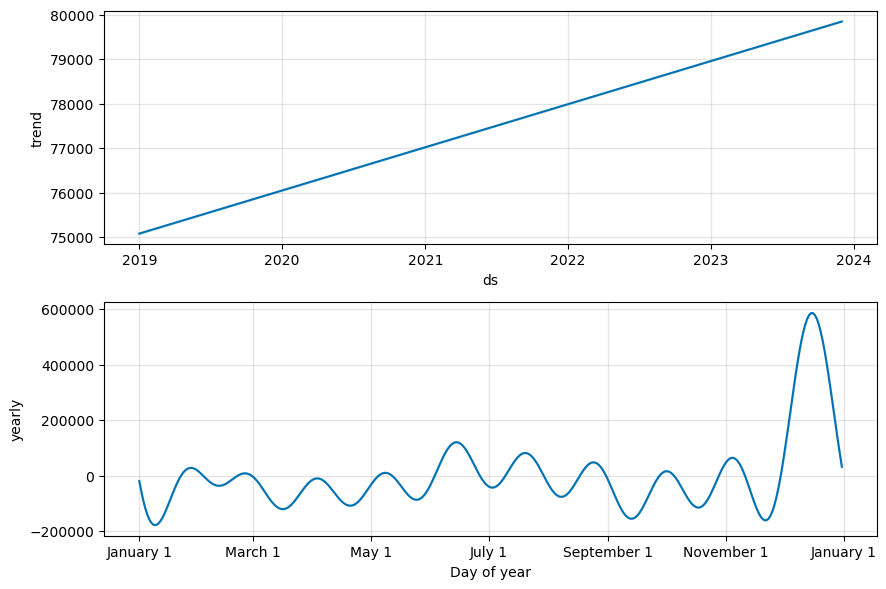

In [24]:
fig2 = model.plot_components(forecast)

In [25]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
48 2023-01-01   79300.864451   57722.607679  101972.023021
49 2023-02-01   95347.127062   75893.498900  116816.554491
50 2023-03-01   77320.735604   55841.119596   99677.458707
51 2023-04-01   63147.298311   40151.302846   84410.205433
52 2023-05-01   41274.511670   20562.448236   61747.593497
53 2023-06-01   41211.123224   20405.467991   62542.451928
54 2023-07-01   42717.175570   21168.040406   63448.087250
55 2023-08-01   53542.331294   32752.082720   73609.858973
56 2023-09-01   69224.883073   47415.519297   91258.272268
57 2023-10-01   94991.904804   71861.147560  116894.802390
58 2023-11-01  122728.235740   99606.301066  143944.838927
59 2023-12-01  128393.456210  106419.547587  151358.314682

In [26]:
sales_j.tail(12) 

ds       y
48 2023-01-01   56843
49 2023-02-01   94268
50 2023-03-01   86135
51 2023-04-01   67767
52 2023-05-01   53500
53 2023-06-01   47080
54 2023-07-01   46924
55 2023-08-01   56348
56 2023-09-01   76393
57 2023-10-01   95597
58 2023-11-01  130293
59 2023-12-01  142757

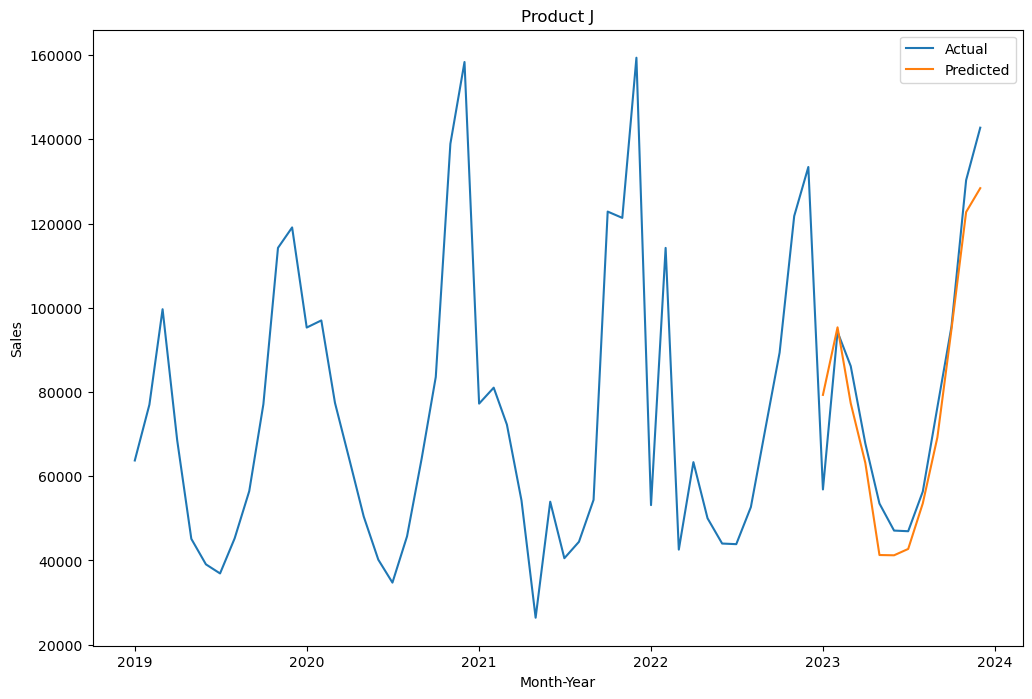

In [27]:
# Reset index of sales_b DataFrame
sales_j_reset_index = sales_j.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_j_reset_index['ds'], sales_j_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product J')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [28]:
#model evaluation

In [29]:
pred=forecasted_df['yhat']
test_df=test['y']

In [30]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 7648.278
MAPE - FB PROPHET: 0.111
MSE - FB PROPHET: 94109467.386
RMSE - FB PROPHET: 9701.003


In [31]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [32]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [33]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   31 days  6.694000e+08  25872.765068  25872.765068  0.487017  0.487017   
1   62 days  6.791551e+08  26060.603715  26060.603715  0.228183  0.228183   
2   90 days  2.438894e+09  49385.157423  49385.157423  1.160393  1.160393   
3  121 days  5.066135e+06   2250.807624   2250.807624  0.035539  0.035539   
4  151 days  5.925210e+07   7697.538317   7697.538317  0.153951  0.153951   
5  182 days  6.638013e+06   2576.434106   2576.434106  0.058555  0.058555   
6  212 days  5.539132e+05    744.253468    744.253468  0.016971  0.016971   
7  243 days  7.347825e+03     85.719453     85.719453  0.001628  0.001628   
8  274 days  2.984462e+07   5463.022882   5463.022882  0.076517  0.076517   
9  304 days  1.225066e+08  11068.271075  11068.271075  0.123885  0.123885   
10 335 days  4.529647e+07   6730.265058   6730.265058  0.055270  0.055270   
11 365 days  7.817754e+07   8841.806138   8841.806138  0.066272  0.066272   

       smape  coverage  
0   0.391647       0.0  
1   0.257570       0.0  
2   0.734335       0.0  
3   0.034919       1.0  
4   0.166789       1.0  
5   0.056890       1.0  
6   0.017116       1.0  
7   0.001629       1.0  
8   0.079561       1.0  
9   0.116659       1.0  
10  0.053784       1.0  
11  0.064146       1.0

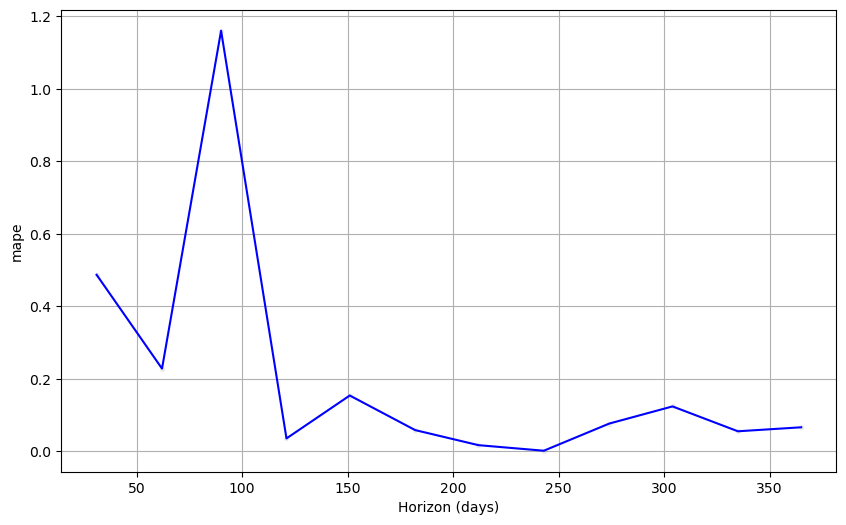

In [34]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

# FORECASTING

In [35]:
model_forecast = Prophet( changepoint_prior_scale= 0.001,seasonality_prior_scale=10.0, seasonality_mode = 'additive',
                interval_width=0.95)

In [36]:
model_forecast.fit(sales_j)

13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=12, freq='MS')  # 12 months in 2024

In [38]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [39]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [40]:
forecasted_f_df

ds           yhat     yhat_lower     yhat_upper
60 2024-01-01   81814.246435   62279.447180  101171.097763
61 2024-02-01   98383.067534   79642.366437  117641.917918
62 2024-03-01   76922.232855   58271.792430   95735.550364
63 2024-04-01   69633.031576   50808.753898   88666.139558
64 2024-05-01   52051.503519   32314.702937   71209.576461
65 2024-06-01   55102.025646   36124.408282   75165.726930
66 2024-07-01   44819.709165   25915.864909   63769.958378
67 2024-08-01   50650.287016   31190.937510   69756.673097
68 2024-09-01   63678.693874   45522.821208   83342.599362
69 2024-10-01   99706.528300   80369.575662  119296.091609
70 2024-11-01  131621.230427  112254.587905  150596.547026
71 2024-12-01  159226.008825  140821.128556  178012.940832

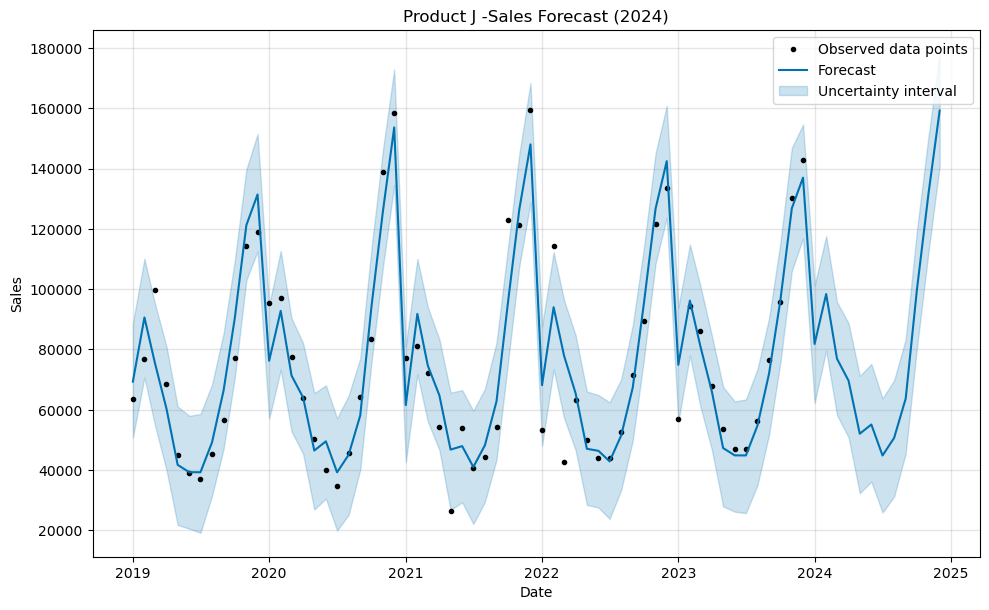

In [41]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product J -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [42]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [43]:
plot_components_plotly(model_forecast, forecast_f)